C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
RNN - MSE: 165.8963, MAPE: 2179813564442700.7500, R²: 0.1792
Bidirectional RNN - MSE: 154.4445, MAPE: 1622859313286713.7500, R²: 0.2358
LSTM - MSE: 171.9632, MAPE: 1684924550960470.2500, R²: 0.1492
Bidirectional LSTM - MSE: 165.1369, MAPE: 1462027845292184.5000, R²: 0.1829


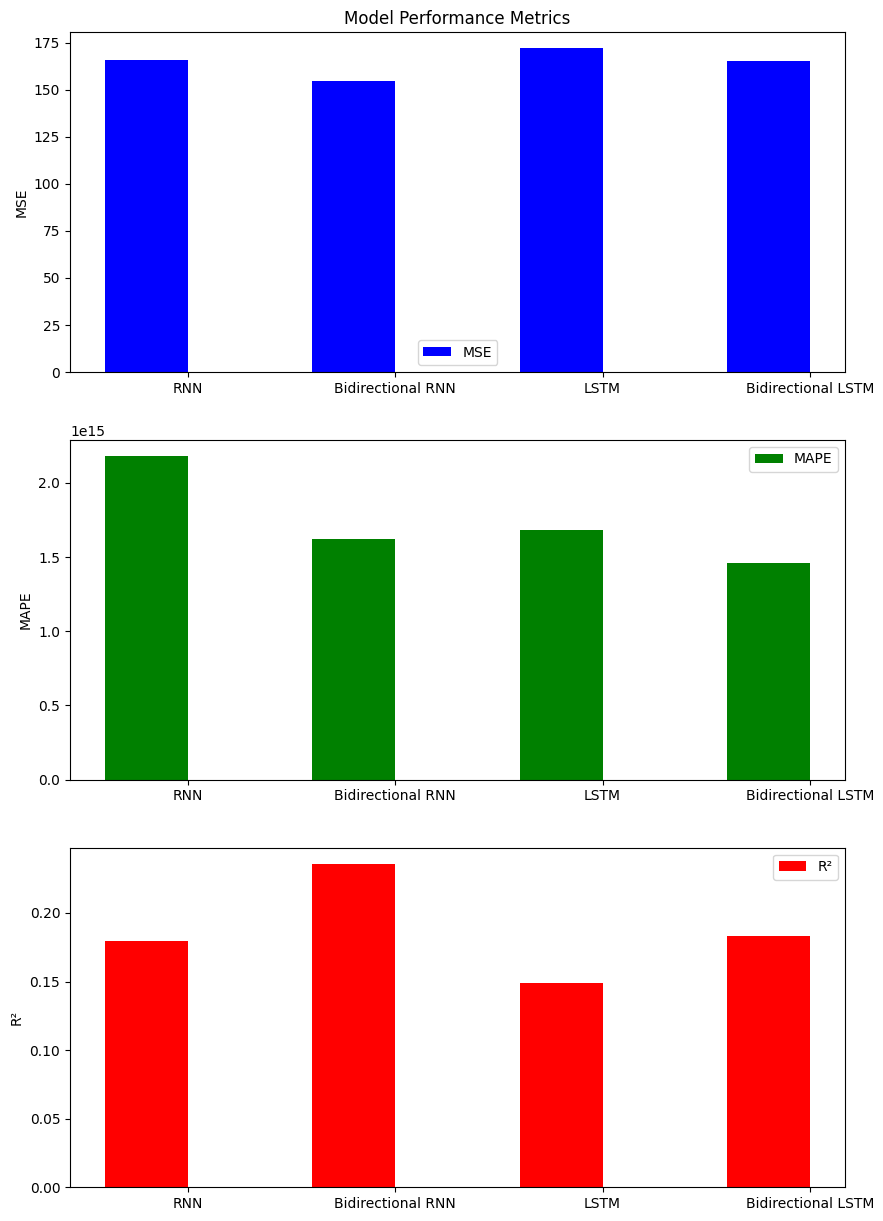

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])
X = data.drop(columns=['HYB'])
y = data['HYB']

# Outlier removal using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from the target column ('HYB')
data_cleaned = remove_outliers_iqr(data, 'HYB')

# Remove outliers from the feature columns
for col in X.columns:
    data_cleaned = remove_outliers_iqr(data_cleaned, col)

# Set X and y again after outlier removal
X = data_cleaned.drop(columns=['HYB']).values
y = data_cleaned['HYB'].values

# Scaling with MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Reshape X for RNN models (samples, time steps, features)
X_scaled_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Function to build and train RNN models
def build_and_train_model(model_type, X_train, y_train):
    model = Sequential()
    
    if model_type == 'RNN':
        model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'Bidirectional RNN':
        model.add(Bidirectional(SimpleRNN(50), input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'Bidirectional LSTM':
        model.add(Bidirectional(LSTM(50), input_shape=(X_train.shape[1], X_train.shape[2])))
        
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    return model

# Train each model
results = {}
for model_type in ['RNN', 'Bidirectional RNN', 'LSTM', 'Bidirectional LSTM']:
    model = build_and_train_model(model_type, X_scaled_reshaped, y_scaled)
    
    # Make predictions
    y_pred_scaled = model.predict(X_scaled_reshaped)
    
    # Inverse scaling
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_actual = scaler_y.inverse_transform(y_scaled.reshape(-1, 1))
    
    # Evaluate the model
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    results[model_type] = {
        'MSE': mse,
        'MAPE': mape,
        'R²': r2
    }

# Print the results
for model_type, metrics in results.items():
    print(f"{model_type} - MSE: {metrics['MSE']:.4f}, MAPE: {metrics['MAPE']:.4f}, R²: {metrics['R²']:.4f}")

# Optionally, plot the results
labels = results.keys()
mse_values = [metrics['MSE'] for metrics in results.values()]
mape_values = [metrics['MAPE'] for metrics in results.values()]
r2_values = [metrics['R²'] for metrics in results.values()]

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].bar(x - 0.2, mse_values, 0.4, label='MSE', color='b')
ax[0].set_ylabel('MSE')
ax[0].set_title('Model Performance Metrics')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

ax[1].bar(x - 0.2, mape_values, 0.4, label='MAPE', color='g')
ax[1].set_ylabel('MAPE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

ax[2].bar(x - 0.2, r2_values, 0.4, label='R²', color='r')
ax[2].set_ylabel('R²')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend()

plt.show()


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
RNN - MSE: 1619.6425, RMSE: 40.2448, MAPE: 5505925714226584.0000, R²: 0.5965
Training Bi-RNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
Bi-RNN - MSE: 1397.5668, RMSE: 37.3840, MAPE: 5878630204345415.0000, R²: 0.6518
Training LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
LSTM - MSE: 1109.7816, RMSE: 33.3134, MAPE: 7936880563802280.0000, R²: 0.7235
Training Bi-LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step
Bi-LSTM - MSE: 1083.0342, RMSE: 32.9095, MAPE: 8763182335203468.0000, R²: 0.7302


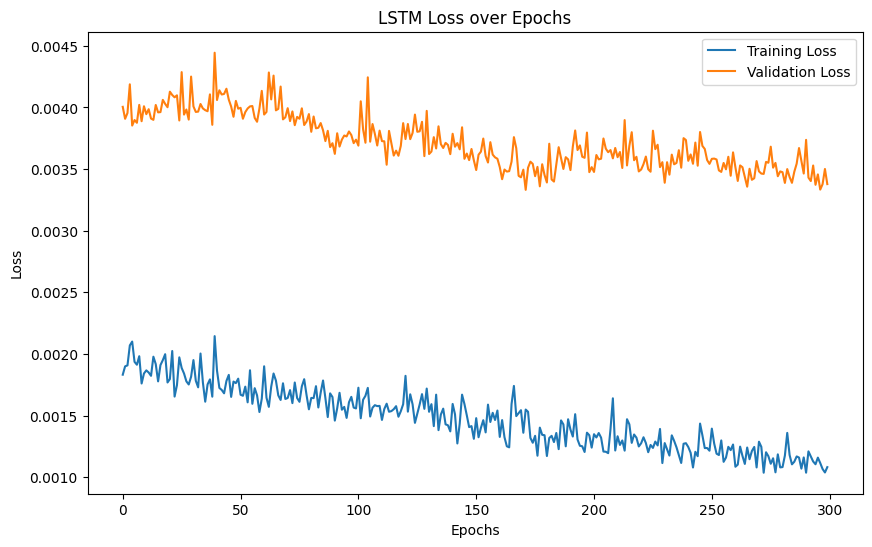

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Create lag features for the target column 'HYB'
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Add lag features and drop NaN values
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()

# Set X and y
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scale the data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for RNN and LSTM (samples, timesteps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to create and compile models
def create_model(model_type='LSTM', layers=1, units=50):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, return_sequences=layers > 1, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    elif model_type == 'Bi-RNN':
        model.add(Bidirectional(SimpleRNN(units, return_sequences=layers > 1), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units, return_sequences=layers > 1, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(units, return_sequences=layers > 1), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))

    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer for regression
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    
    # Predictions
    predictions_scaled = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

    # Metrics
    mse = mean_squared_error(y_test_rescaled, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
    r2 = r2_score(y_test_rescaled, predictions)

    # Print Metrics
    print(f"{model_name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R²: {r2:.4f}")

    return history

# Model types to evaluate
models = {
    'RNN': create_model(model_type='RNN'),
    'Bi-RNN': create_model(model_type='Bi-RNN'),
    'LSTM': create_model(model_type='LSTM'),
    'Bi-LSTM': create_model(model_type='Bi-LSTM'),
}

# Train and evaluate all models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    train_and_evaluate_model(model, X_train_rnn, y_train, X_test_rnn, y_test, model_name)

# Plotting training and validation loss for one model (example: LSTM)
plt.figure(figsize=(10, 6))
history_lstm = models['LSTM'].fit(X_train_rnn, y_train, epochs=300, batch_size=16, validation_data=(X_test_rnn, y_test), verbose=0)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Load the dataset
data = pd.read_csv('new_data2.csv')

# Drop the date column and set X, y
data = data.drop(columns=['date(dd/mm/yy)'])

# Create lag features for the target column 'HYB'
def create_lag_features(data, column, n_lags=3):
    for lag in range(1, n_lags + 1):
        data[f'{column}_lag{lag}'] = data[column].shift(lag)
    return data

# Add lag features and drop NaN values
data_lagged = create_lag_features(data, 'HYB', n_lags=3)
data_lagged = data_lagged.dropna()

# Set X and y
X = data_lagged.drop(columns=['HYB']).values
y = data_lagged['HYB'].values

# Scale the data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for RNN and LSTM (samples, timesteps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Function to create and compile models
def create_model(model_type='LSTM', layers=1, units=50):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, return_sequences=layers > 1, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    elif model_type == 'Bi-RNN':
        model.add(Bidirectional(SimpleRNN(units, return_sequences=layers > 1), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units, return_sequences=layers > 1, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(units, return_sequences=layers > 1), input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))

    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer for regression
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test), verbose=0)
    
    # Predictions
    predictions_scaled = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions_scaled)
    y_test_rescaled = scaler_y.inverse_transform(y_test)

    # Metrics
    mse = mean_squared_error(y_test_rescaled, predictions)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_rescaled, predictions)
    r2 = r2_score(y_test_rescaled, predictions)

    # Print Metrics
    print(f"{model_name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R²: {r2:.4f}")

    return history

# Train and evaluate RNN and LSTM models
models = {
    'RNN': create_model(model_type='RNN'),
    'Bi-RNN': create_model(model_type='Bi-RNN'),
    'LSTM': create_model(model_type='LSTM'),
    'Bi-LSTM': create_model(model_type='Bi-LSTM'),
}

# Train and evaluate all models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    train_and_evaluate_model(model, X_train_rnn, y_train, X_test_rnn, y_test, model_name)

# Train and evaluate ARMA and Multivariate ARIMA models
def check_stationarity(series):
    """Check if a time series is stationary."""
    result = adfuller(series)
    return result[1] < 0.05  # Returns True if stationary

# Check if 'HYB' is stationary
if check_stationarity(data['HYB']):
    print("The 'HYB' series is stationary.")
else:
    print("The 'HYB' series is not stationary. Consider differencing or transforming.")

# Fit ARMA model
# order = (2, 0)  # You may want to tune this order
arma_model = ARIMA(data['HYB'], order=3)
arma_model_fit = arma_model.fit()
arma_predictions = arma_model_fit.forecast(steps=len(y_test))

# Metrics for ARMA model
arma_mse = mean_squared_error(y_test, arma_predictions)
arma_rmse = np.sqrt(arma_mse)
arma_mape = mean_absolute_percentage_error(y_test, arma_predictions)
arma_r2 = r2_score(y_test, arma_predictions)

print(f"ARMA - MSE: {arma_mse:.4f}, RMSE: {arma_rmse:.4f}, MAPE: {arma_mape:.4f}, R²: {arma_r2:.4f}")

# Fit Multivariate ARIMA model if applicable (using lag features)
# Assuming we want to include lag features in the model
if 'HYB_lag1' in data_lagged.columns:
    multivariate_order = (2, 0, 2)  # This is also subject to tuning
    multivariate_arima_model = ARIMA(data_lagged['HYB'], order=multivariate_order, exog=data_lagged.drop(columns=['HYB']))
    multivariate_arima_model_fit = multivariate_arima_model.fit()
    multivariate_arima_predictions = multivariate_arima_model_fit.forecast(steps=len(y_test), exog=X_test)

    # Metrics for Multivariate ARIMA model
    multivariate_arima_mse = mean_squared_error(y_test, multivariate_arima_predictions)
    multivariate_arima_rmse = np.sqrt(multivariate_arima_mse)
    multivariate_arima_mape = mean_absolute_percentage_error(y_test, multivariate_arima_predictions)
    multivariate_arima_r2 = r2_score(y_test, multivariate_arima_predictions)

    print(f"Multivariate ARIMA - MSE: {multivariate_arima_mse:.4f}, RMSE: {multivariate_arima_rmse:.4f}, MAPE: {multivariate_arima_mape:.4f}, R²: {multivariate_arima_r2:.4f}")
else:
    print("Lag features for Multivariate ARIMA model are not available.")

# Plotting training and validation loss for one model (example: LSTM)
plt.figure(figsize=(10, 6))
history_lstm = models['LSTM'].fit(X_train_rnn, y_train, epochs=300, batch_size=16, validation_data=(X_test_rnn, y_test), verbose=0)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
RNN - MSE: 1598.6026, RMSE: 39.9825, MAPE: 4684932536192744.0000, R²: 0.6018
Training Bi-RNN...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
Bi-RNN - MSE: 1516.0808, RMSE: 38.9369, MAPE: 5309746001617682.0000, R²: 0.6223
Training LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
LSTM - MSE: 1084.9995, RMSE: 32.9393, MAPE: 8581517397462535.0000, R²: 0.7297
Training Bi-LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
Bi-LSTM - MSE: 1138.8749, RMSE: 33.7472, MAPE: 8506125365438774.0000, R²: 0.7163
The 'HYB' series is stationary.


TypeError: 'int' object is not subscriptable

: 